In [2]:
import os
import copy

import PIL.Image
import pandas as pd
import numpy as np
import concurrent.futures
import matplotlib.pyplot as plt

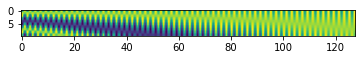

In [12]:
def _get_positional_encoding(g, n_hiddens):
        pe = np.zeros((g, n_hiddens))
        for pos in range(g):
            for i in range(0, n_hiddens, 2):
                demon = 3 ** ((2 * i) / n_hiddens)
                pe[pos, i] = np.sin(pos / demon)
                pe[pos, i + 1] = np.cos(pos / demon)
        return pe
    
pe = _get_positional_encoding(10, 128)

plt.imshow(pe)

In [3]:
W, H = 128, 128  # global width and height for image resolution
VOL = '/s/chopin/l/grad/stock/nvme/data/ai2es/mlhub/nasa_tc'

In [4]:
def partition_data_by_storm(train_df, test_df, train_fraction=0.8, seed=1):
    storms = train_df.storm_id.unique()
    n_storms = len(storms)
    train_frac = int(n_storms * train_fraction)
    inds = np.arange(n_storms)

    np.random.seed(seed)
    np.random.shuffle(inds)

    train_storm_ids = storms[inds[:train_frac]]
    val_storm_ids = storms[inds[train_frac:]]

    train = train_df.loc[train_df.storm_id.isin(
        train_storm_ids)].reset_index(drop=True)
    val = train_df.loc[train_df.storm_id.isin(
        val_storm_ids)].reset_index(drop=True)

    return train, val, test_df

def read_images(files, threads=12):
    """Read images by filenames to a numpy array

    N = number of images
    W = width of images
    H = height of images
    C = number of channels 

    :param files: list of files to read
    :param threads: number of threads to use for reading
    :return: images: (N,W,H,C) numpy array of images
    """
    def _reading_thread(files, n_images, section):
        """Helper function for reading in different threads"""
        for i, f in enumerate(files[section:section+n_images]):
            with PIL.Image.open(f).convert('L') as im:
                # convert from 366 x 366 to ...
                images[i + section] = np.expand_dims(im.resize((W, H)), axis=0) / 255.

    images = np.zeros((len(files), 1, W, H))
    n_images = len(files) // threads

    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        for section in [n_images * i for i in range(threads + 1)]:
            executor.submit(_reading_thread, files, n_images, section)

    return images


def load_data(train, val, test):
    """Convert DataFrame to numpy array for training, 
    validation, and test datasets

    F = number of target output features

    :param train: _training_ df with file_name and wind_speed variables 
    :param val: _validation_ df with file_name and wind_speed variables 
    :param test: _test_ df with file_name and wind_speed variables 
    :return: X_: (N,W,H,C) numpy array of _ images
    :return: T_: (N,F) numpy array of _ targets
    """
    Xtrain = read_images(train.file_name.values)
    Ttrain = train.wind_speed.values.reshape(-1, 1)

    Xval = read_images(val.file_name.values)
    Tval = val.wind_speed.values.reshape(-1, 1)

    Xtest = read_images(test.file_name.values)
    Ttest = test.wind_speed.values.reshape(-1, 1)

    return Xtrain, Ttrain, Xval, Tval, Xtest, Ttest

In [5]:
train_df = pd.read_csv(os.path.join(VOL, 'train_metadata.csv'))
test_df = pd.read_csv(os.path.join(VOL, 'test_metadata.csv'))
train, val, test = partition_data_by_storm(train_df, test_df, train_fraction=0.8, seed=1)

In [6]:
train.shape, val.shape, test.shape

((56664, 8), (13593, 8), (44377, 8))

In [7]:
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = load_data(train, val, test)

In [8]:
def categorize(targets):
    """
    Saffir-Simpson Hurricane Wind Scale
    1: 64-82 kt
    2: 83-95 kt
    3: 96-112 kt
    4: 113-136 kt
    5: 137 kt or higher
    """
    T = copy.deepcopy(targets)
#     T[T < 50] = -1
#     T[(T >= 50) & (T <= 63)] = 0
#     T[(T >= 64) & (T <= 82)] = 1
#     T[(T >= 83) & (T <= 95)] = 2
#     T[(T >= 96) & (T <= 112)] = 3
#     T[(T >= 113) & (T <= 136)] = 4
#     T[T >= 137] = 5
    T[T < 50] = -1
    T[(T >= 50) & (T <= 63)] = 0
    T[(T >= 64) & (T <= 95)] = 1
    T[T > 95] = 3
    return T

In [9]:
Ttrain = categorize(Ttrain)
inds = np.where(Ttrain == -1)
Xtrain = np.delete(Xtrain, inds, 0)
Ttrain = np.delete(Ttrain, inds, 0).astype(int)

Tval = categorize(Tval)
inds = np.where(Tval == -1)
Xval = np.delete(Xval, inds, 0)
Tval = np.delete(Tval, inds, 0).astype(int)

Ttest = categorize(Ttest)
inds = np.where(Ttest == -1)
Xtest = np.delete(Xtest, inds, 0)
Ttest = np.delete(Ttest, inds, 0).astype(int)

In [10]:
Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((22263, 1, 128, 128),
 (22263, 1),
 (5719, 1, 128, 128),
 (5719, 1),
 (15180, 1, 128, 128),
 (15180, 1))

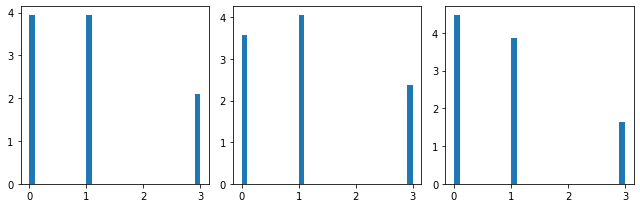

In [11]:
fig, axs = plt.subplots(1,3, figsize=(9,3))
axs[0].hist(Ttrain, density=True, stacked=True, bins=30)
axs[1].hist(Tval, density=True, stacked=True, bins=30)
axs[2].hist(Ttest, density=True, stacked=True, bins=30);

fig.tight_layout()